<a href="https://colab.research.google.com/github/showmik121/Genetivie_AI/blob/main/Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔧 What is Hyperparameter Tuning?
When you build a machine learning or deep learning model, you set some values before training starts — these are called hyperparameters.

📌 Examples of hyperparameters:

Learning rate

Number of hidden layers

Number of neurons in each layer

Batch size

Number of epochs

Dropout rate

Optimizer type (Adam, SGD, etc.)

Tuning means trying different combinations of these hyperparameters to find the best-performing model (e.g., highest accuracy, lowest loss).

✅ Why Hyperparameter Tuning?
Different hyperparameters can give very different results. The goal is to:

Improve accuracy

Avoid overfitting or underfitting

Train faster

**🤖 What is Bayesian Optimization?
Bayesian Optimization is a smart search technique. It works like this:

Try a few random hyperparameters.

See how well they perform.

Predict which combination might work best next (using probability).

Try the new suggestion.

Repeat until the best one is found!

🔁 It keeps learning from past results to choose better next steps.**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,Dataset
import matplotlib.pyplot as plt

In [2]:
# set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
df=pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

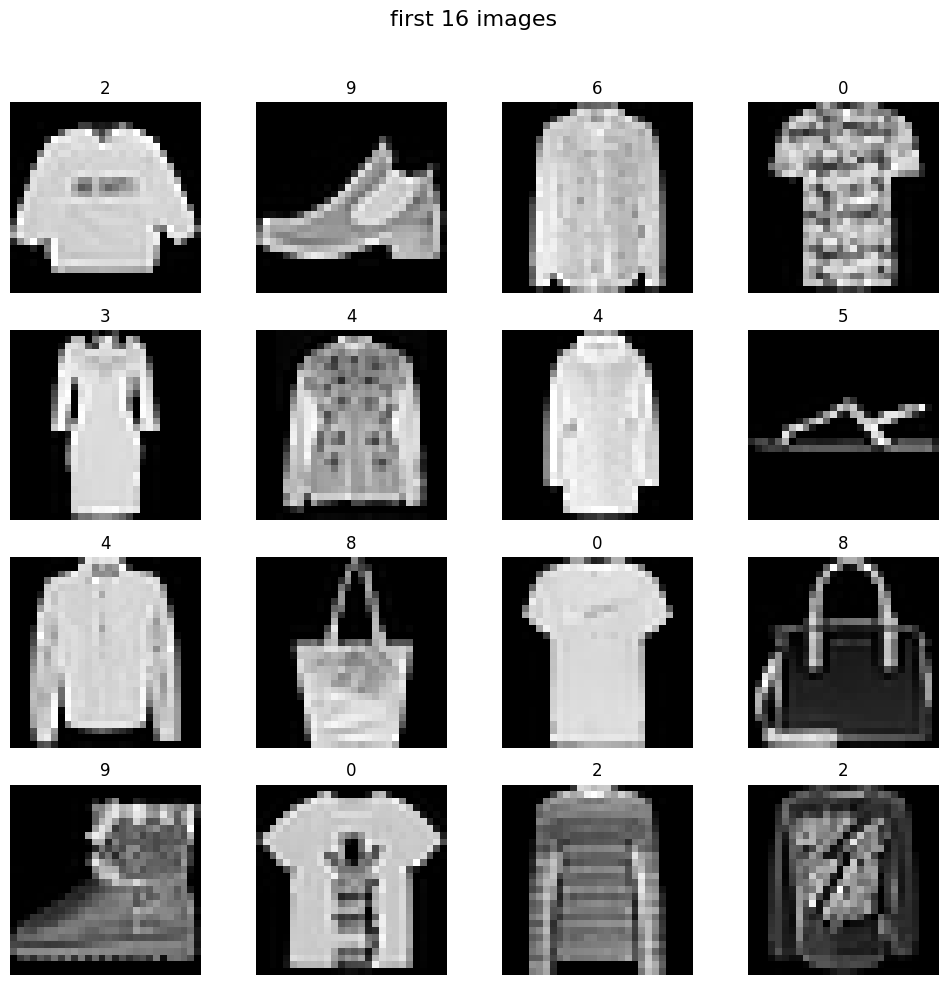

In [7]:
# create a 4x4 graid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("first 16 images", fontsize=16)
axes = axes.flatten()
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(df.iloc[i, 0])
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [8]:
# train text spilt
x=df.iloc[:,1:].values
y=df.iloc[:,0].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [9]:
# scaling the feautures
x_train=x_train/255.0
x_test=x_test/255.0


In [10]:
# create customDataset class
class CustomDataset(Dataset):
    def __init__(self,feautures,labels):
        self.feautures=torch.tensor(feautures,dtype=torch.float32)
        self.labels=torch.tensor(labels,dtype=torch.long)

    def __len__(self):
        return len(self.feautures)

    def __getitem__(self,idx):
       return self.feautures[idx],self.labels[idx]



In [11]:
# create train_dataset object
train_dataset=CustomDataset(x_train,y_train)


In [12]:
# create test_dataset object
test_dataset=CustomDataset(x_test,y_test)

In [32]:
# ✅ Define FashionMNISTModel outside the objective function
class FashionMNISTModel(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
        super(FashionMNISTModel, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_dim, neurons_per_layer))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))


        # Output layer
        layers.append(nn.Linear(neurons_per_layer, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)



In [37]:
def objective(trial):
    try:
        # Hyperparameter search space
        num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
        neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
        weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
        epochs = trial.suggest_int("epochs", 10, 50)

        # DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

        # Model
        input_dim = 784
        output_dim = 10
        model = FashionMNISTModel(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate).to(device)

        loss_fn = nn.CrossEntropyLoss()
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # Training loop
        for epoch in range(epochs):
            model.train()
            for features, labels in train_loader:
                features, labels = features.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(features.view(features.size(0), -1))  # Flatten
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for features, labels in test_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features.view(features.size(0), -1))
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy  # ✅ Make sure this always returns a float!

    except Exception as e:
        trial.set_user_attr("exception", str(e))
        return 0.0  # If any trial crashes, it returns 0 accuracy instead of None


In [ ]:
pip install optuna

In [38]:
# run optuna Hyperparameter tuning
import optuna
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=5)

[I 2025-04-04 19:41:22,992] A new study created in memory with name: no-name-0698d599-4b5c-4649-af2c-12fdc8c4b700
[I 2025-04-04 19:42:33,743] Trial 0 finished with value: 87.64166666666667 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 72, 'dropout_rate': 0.30522347343320266, 'learning_rate': 0.015208524777803272, 'batch_size': 64, 'weight_decay': 0.0009736206596783169, 'optimizer': 'SGD', 'epochs': 27}. Best is trial 0 with value: 87.64166666666667.
[I 2025-04-04 19:47:43,933] Trial 1 finished with value: 88.36666666666666 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 112, 'dropout_rate': 0.305830509984368, 'learning_rate': 1.88638580878858e-05, 'batch_size': 32, 'weight_decay': 0.00039843106094384544, 'optimizer': 'Adam', 'epochs': 45}. Best is trial 1 with value: 88.36666666666666.
[I 2025-04-04 19:52:53,625] Trial 2 finished with value: 52.99166666666667 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 32, 'dropout_rate': 0.43669326828968

In [39]:
study.best_value

88.39166666666667

In [40]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_per_layer': 72,
 'dropout_rate': 0.25397133158545127,
 'learning_rate': 8.344722211592278e-05,
 'batch_size': 64,
 'weight_decay': 0.0019733237582096087,
 'optimizer': 'Adam',
 'epochs': 42}